# Задание

Реализовать mel-спектрограмму с использованием numpy и библиотеки чтения аудиофайла(например, soundfile)
Визуализировать можно с помощью matplotlib

# Решение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

Mel-спектрограмма — матрица энергий спектра, спроецированная с линейной оси частот (Гц) на психоакустическую шкалу mel.

## Чтение файла

In [ ]:
amplitudes, samplerate = sf.read('AEG_1934.mp3')

# data - массив с амплитудами звукового сигнала
# samplerate - частота дискретизации

print("Форма массива:", amplitudes.shape)
print("Частота дискретизации:", samplerate)

Форма массива: (7797760, 2)
Частота дискретизации: 44100


In [8]:
# Так как канала два, объединим их в один усреднением
if len(amplitudes.shape) == 2:
    amplitudes = amplitudes.mean(axis=1)

## Поделим сигнал (список амплитуд) на фреймы по 30 мс с шагом 10 мс

Короткие окна (20–40 мс) позволяют фикcировать локальные частотные характеристики звука

In [12]:
window_size = 0.03  # 25 ms
step_size = 0.01  # 10 ms

frame_size = int(window_size * samplerate)  # размер фрейма в сэмплах
hop_size = int(step_size * samplerate)    # шаг окна

frames = []
for start in range(0, len(amplitudes) - frame_size, hop_size):
    frame = amplitudes[start:start + frame_size]
    # применяем окно Хэмминга
    frame = frame * np.hamming(frame_size)
    frames.append(frame)

frames = np.array(frames)  # Размер (num_frames, frame_size)
print(f'frames shape = {frames.shape}')

frames shape = (17679, 1323)


## Fast Fourier transformation

In [ ]:
NFFT = 2048  # размер FFt
mag_frames = np.abs(np.fft.rfft(frames, n=NFFT))  # амплитуда сигнала на данной частоте (модуль спектра)
# n=NFFT задает количество точек для вычисления БПФ, дополняя нулями размерность фрейма автоматически
# на выходе отрицательные частоты отбрасываются в силу симметрии спектра

power_frames = (1.0 / NFFT) * (mag_frames ** 2)  # энергия сигнала на данной частоте

print(f'mag_frames shape = {power_frames.shape}')

mag_frames shape = (17679, 1025)


## Перевод частот в mel

In [ ]:
def hz_to_mel(hz):
    """Переводим частоты из Гц в мел"""
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    """Переводим мел в частоты Гц"""
    return 700 * (10**(mel / 2595) - 1)

In [35]:
n_mels = 80  # количество mel-фильтров
fmin = 0
fmax = samplerate / 2

# равномерные узлы в mel и в hz
mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), n_mels + 2)
hz_points = mel_to_hz(mel_points)

# индексы в спектре
bin_points = np.floor((NFFT + 1) * hz_points / samplerate).astype(int)


## Треугольные mel-фильтры

In [36]:
filters = np.zeros((n_mels, NFFT//2 + 1))

for i in range(1, n_mels + 1):
    left = bin_points[i - 1]
    center = bin_points[i]
    right = bin_points[i + 1]
    
    # растущая сторона
    filters[i - 1, left:center] = np.linspace(0, 1, center - left)
    # падающая сторона
    filters[i - 1, center:right] = np.linspace(1, 0, right - center)


## Проекция мощности на mel-полосы

In [37]:
mel_energy = np.dot(power_frames, filters.T)  # Размерность (num_frames, n_mels)

## Перевод в децибелы

In [38]:
mel_db = 10 * np.log10(np.maximum(mel_energy, 1e-10))

## mel-спектрограмма

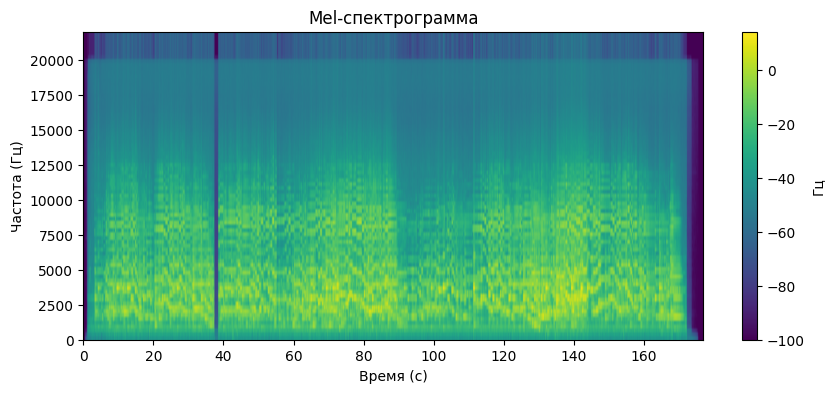

In [50]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_db.T, 
           origin='lower', 
           aspect='auto', 
           extent=[0, len(amplitudes)/samplerate, fmin, fmax],
           cmap=None
           )
plt.xlabel("Время (с)")
plt.ylabel("Частота (Гц)")
plt.title("Mel-спектрограмма")
plt.colorbar(label="Гц")
plt.show()